In [1]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import keras
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [2]:
# latency_dataset = "../latency_datasets/Dataset_3"
latency_dataset = ""
search_space_len = 382

In [3]:
df_in = pd.read_csv(f"{latency_dataset}table.csv")
df_in.head()

,model,params [K],sipeed_latency [ms],kmodel_memory [KB],cpu_latency [ms],accuracy,token_sequence,length,model_info
0,model_001,1.834,NaN,NaN,NaN,0.49,"[59, 305, 301, 302, 204, 35, 382]",7,"{""0"": [""Conv2D"", 16, [2, 2], [3, 3], ""same"", ""..."
1,model_002,8.544,NaN,NaN,NaN,0.49,"[206, 39, 257, 143, 287, 351, 382]",7,"{""0"": [""DepthwiseConv2D"", 8, [3, 3], [1, 1], ""..."
2,model_003,138.578,NaN,NaN,NaN,0.73,"[81, 194, 157, 382]",4,"{""0"": [""Conv2D"", 24, [1, 1], [3, 3], ""valid"", ..."
3,model_004,1.065,NaN,NaN,NaN,0.63,"[202, 35, 270, 382]",4,"{""0"": [""DepthwiseConv2D"", 8, [2, 2], [3, 3], ""..."
4,model_005,43.762,NaN,NaN,NaN,0.69,"[28, 150, 172, 321, 157, 110, 177, 101, 253, 3...",11,"{""0"": [""Conv2D"", 8, [3, 3], [1, 1], ""same"", ""r..."


In [4]:
df = df_in
df["token_sequence"] = df["token_sequence"].apply(lambda x: json.loads(x))

longest_len = max([len(i) for i in list(df["token_sequence"].values)])  # add zero to make all lengths equal
for i in df["token_sequence"].values:
    for _ in range(longest_len - len(i)):
        i.append(0)

df_tokens = pd.DataFrame.from_dict(dict(zip(df["token_sequence"].index, df["token_sequence"].values))).T
df_tokens.columns = [f"layer_{i}" for i in range(1, len(df_tokens.columns)+1)]
df_tokens["accuracy"] = df["accuracy"]
df = df_tokens
print(len(df))
df.head()

500


,layer_1,layer_2,layer_3,layer_4,layer_5,layer_6,layer_7,layer_8,layer_9,layer_10,layer_11,layer_12,layer_13,layer_14,layer_15,accuracy
0,59,305,301,302,204,35,382,0,0,0,0,0,0,0,0,0.49
1,206,39,257,143,287,351,382,0,0,0,0,0,0,0,0,0.49
2,81,194,157,382,0,0,0,0,0,0,0,0,0,0,0,0.73
3,202,35,270,382,0,0,0,0,0,0,0,0,0,0,0,0.63
4,28,150,172,321,157,110,177,101,253,340,382,0,0,0,0,0.69


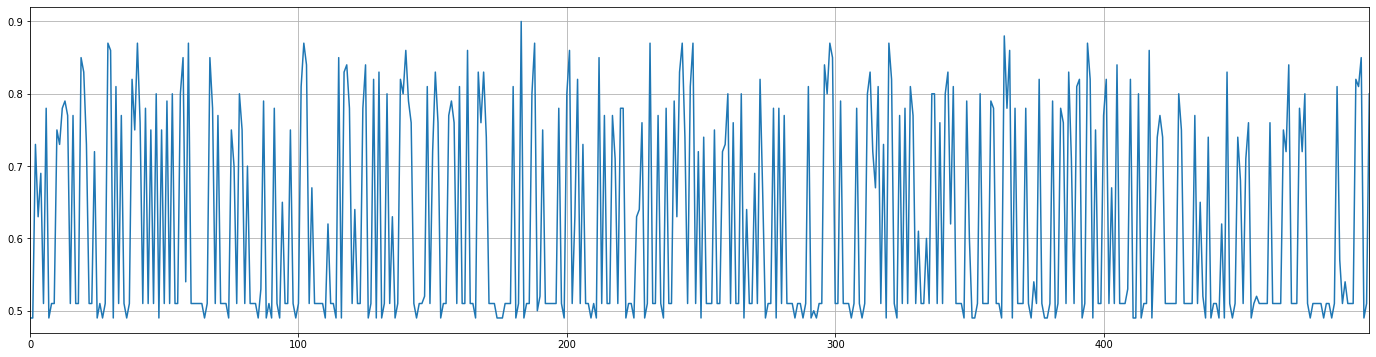

In [5]:
df["accuracy"].plot(figsize=(24, 6))
plt.grid()
plt.show()

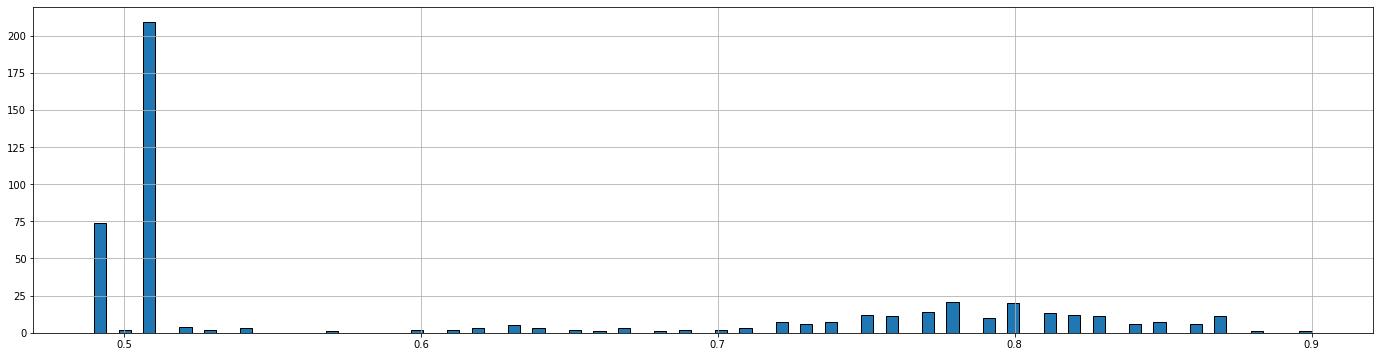

In [15]:
df["accuracy"].hist(bins=100, edgecolor="k", figsize=(24, 6))
plt.show()

In [11]:
print("Max:", np.max(df["accuracy"]))
print("Min:", np.min(df["accuracy"]))
print("Mean:", np.mean(df["accuracy"]))

Max: 0.9
Min: 0.49
Mean: 0.6162199999999999


In [7]:
# remove outliers
# df = df[df["accuracy"] <= 100]
# print(len(df))

In [8]:
x = df.loc[:, df.columns != "accuracy"]
y = df.loc[:, df.columns == "accuracy"]

In [9]:
# enc = OneHotEncoder(handle_unknown='ignore')
# x_hot = enc.fit_transform(x).toarray()

In [10]:
x_hot = keras.utils.to_categorical(x, num_classes=search_space_len+1)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_hot, y, test_size=0.1, random_state=42)

print("x_train:", x_train.shape)
print("x_test:", x_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

x_train: (450, 15, 383)
x_test: (50, 15, 383)
y_train: (450, 1)
y_test: (50, 1)


In [12]:
model = None
model = keras.models.Sequential()
model.add(keras.layers.Dense(64, input_shape=(longest_len, search_space_len+1), activation='relu'))  # input shape: (15, 383)
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='linear'))

optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15, 64)            24576     
_________________________________________________________________
dense_1 (Dense)              (None, 15, 64)            4160      
_________________________________________________________________
dense_2 (Dense)              (None, 15, 32)            2080      
_________________________________________________________________
dense_3 (Dense)              (None, 15, 32)            1056      
_________________________________________________________________
dense_4 (Dense)              (None, 15, 32)            1056      
_________________________________________________________________
dense_5 (Dense)              (None, 15, 16)            528       
_________________________________________________________________
dense_6 (Dense)              (None, 15, 16)            2

In [13]:
# reset weights
# model = keras.models.clone_model(model)
# optimizer = keras.optimizers.Adam(lr=0.001)
# model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [14]:
history = model.fit(x_train, y_train, epochs=200, validation_split=0.1, verbose=3)

Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200
Epoch 71/200
Epoch 72/200
Epoch 73/200
Epoch 74/200
Epoch 75/200
Epoch 76/200
Epoch 77/200
Epoch 78

In [15]:
print(history.history["val_loss"][-1])
print(history.history["val_mae"][-1])

0.02513909339904785
0.10430260002613068


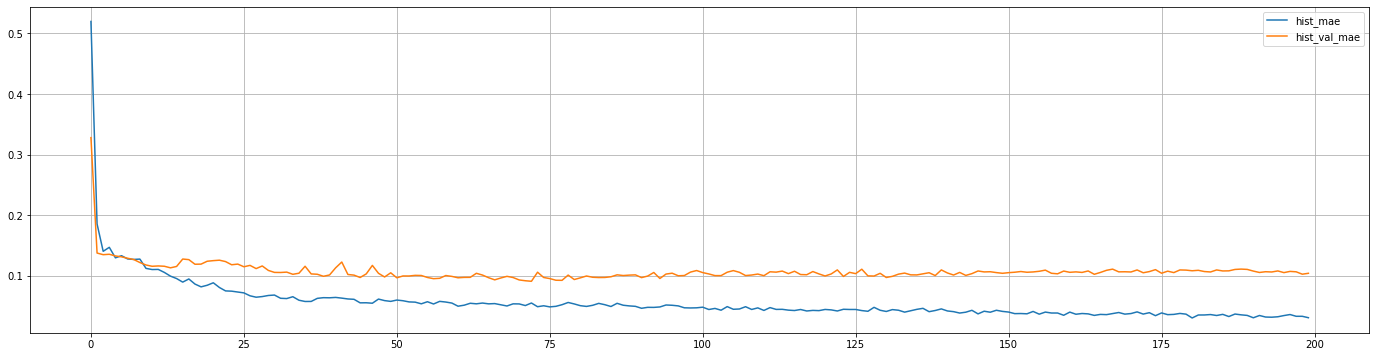

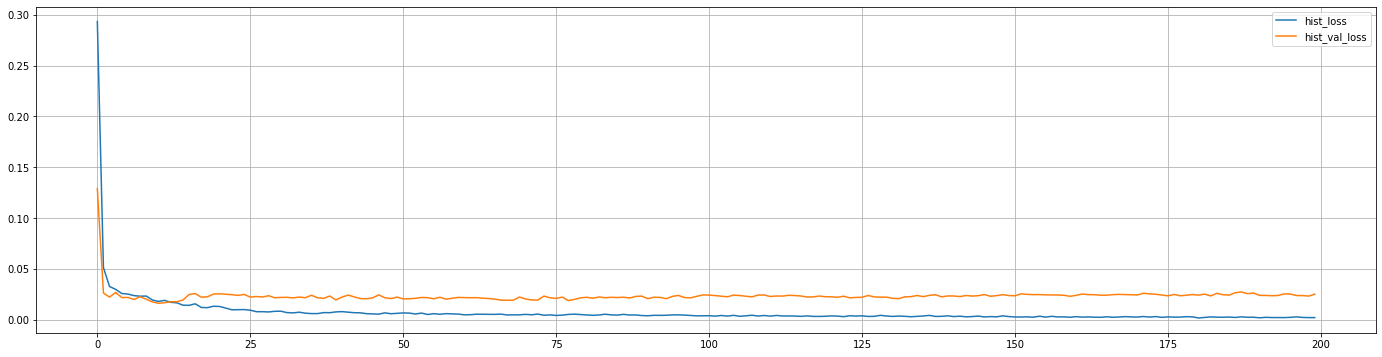

In [16]:
hist_loss = history.history["loss"]
hist_mae = history.history["mae"]
hist_val_loss = history.history["val_loss"]
hist_val_mae = history.history["val_mae"]

fig = plt.figure(figsize=(24, 6))
plt.plot(np.arange(len(hist_mae)), hist_mae, label="hist_mae")
plt.plot(np.arange(len(hist_val_mae)), hist_val_mae, label="hist_val_mae")
plt.grid()
plt.legend()
plt.show()

fig = plt.figure(figsize=(24, 6))
plt.plot(np.arange(len(hist_loss)), hist_loss, label="hist_loss")
plt.plot(np.arange(len(hist_val_loss)), hist_val_loss, label="hist_val_loss")
plt.grid()
plt.legend()
plt.show()

In [17]:
mse_nn, mae_nn = model.evaluate(x_test, y_test)
print("mse: ", mse_nn)
print("mae: ", mae_nn)

2/2 [==============================] - 0s 6ms/step - loss: 0.0188 - mae: 0.0826
mse:  0.018796930089592934
mae:  0.08264356851577759


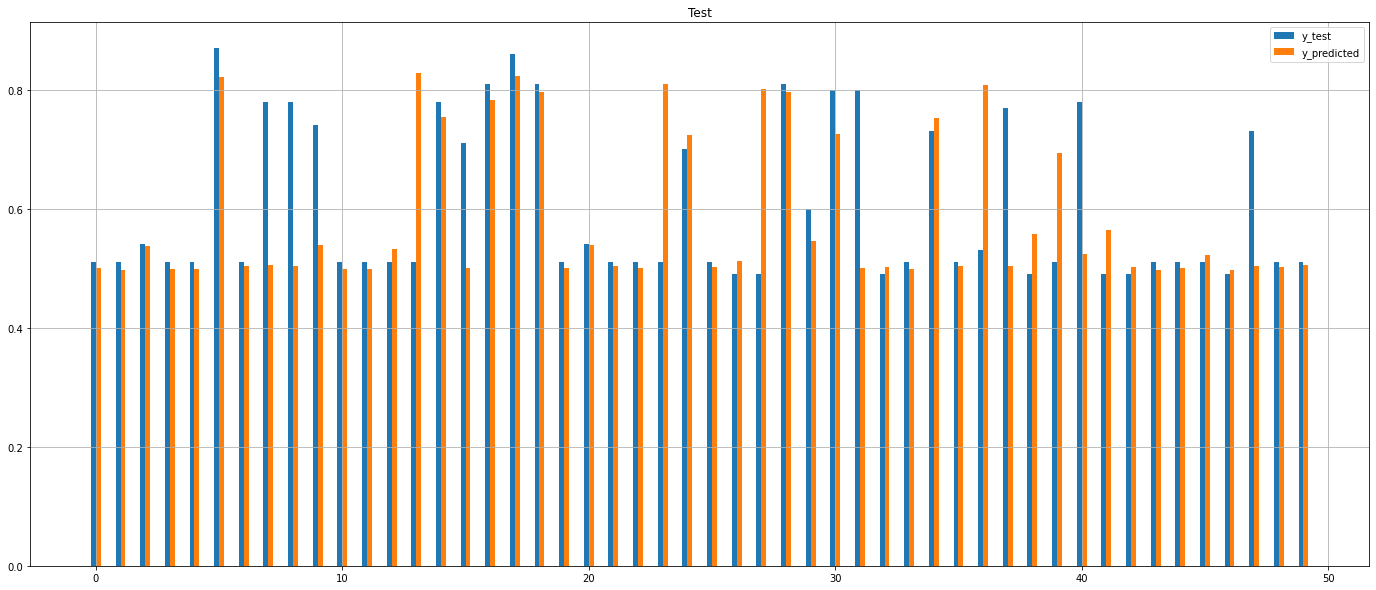

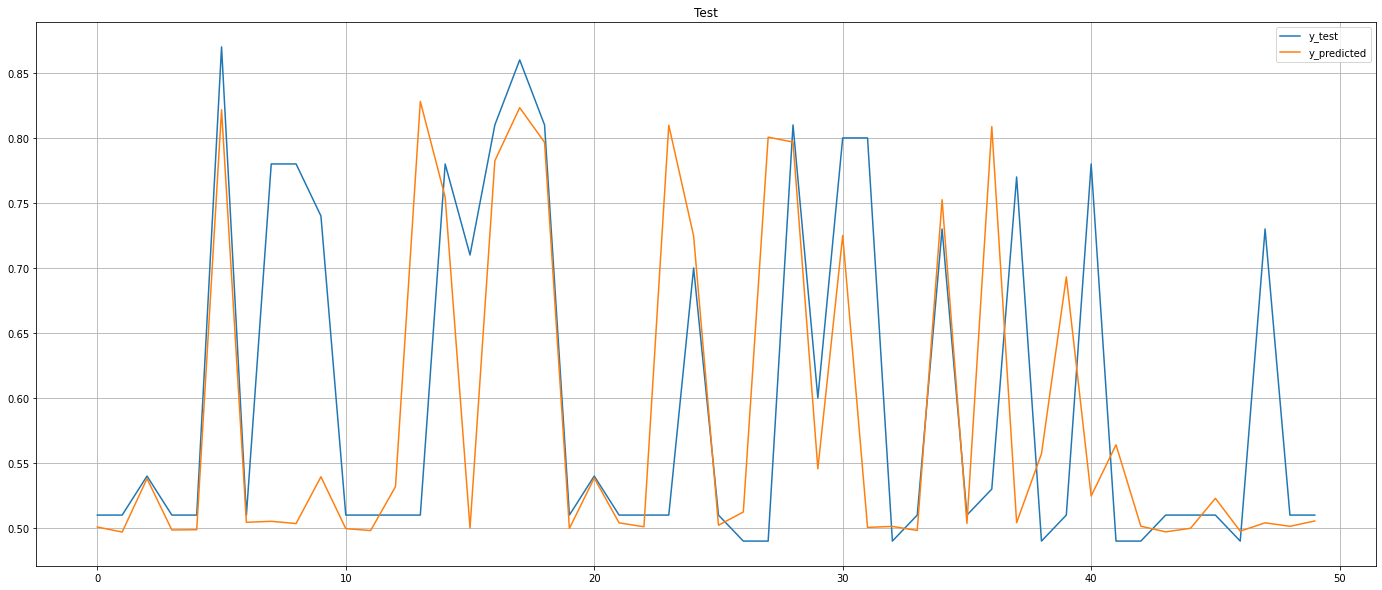

In [18]:
y_predicted = model.predict(x_test)

width = 0.2
fig = plt.figure(figsize=(24, 10))
plt.bar(np.arange(len(y_test)) - width/2, y_test["accuracy"].to_list(), width, label="y_test")
plt.bar(np.arange(len(y_test)) + width/2, y_predicted.flatten(), width, label="y_predicted")
plt.title("Test")
plt.grid()
plt.legend()
plt.show()

fig = plt.figure(figsize=(24, 10))
plt.plot(np.arange(len(y_test)), y_test, label="y_test")
plt.plot(np.arange(len(y_predicted)), y_predicted, label="y_predicted")
plt.title("Test")
plt.grid()
plt.legend()
plt.show()

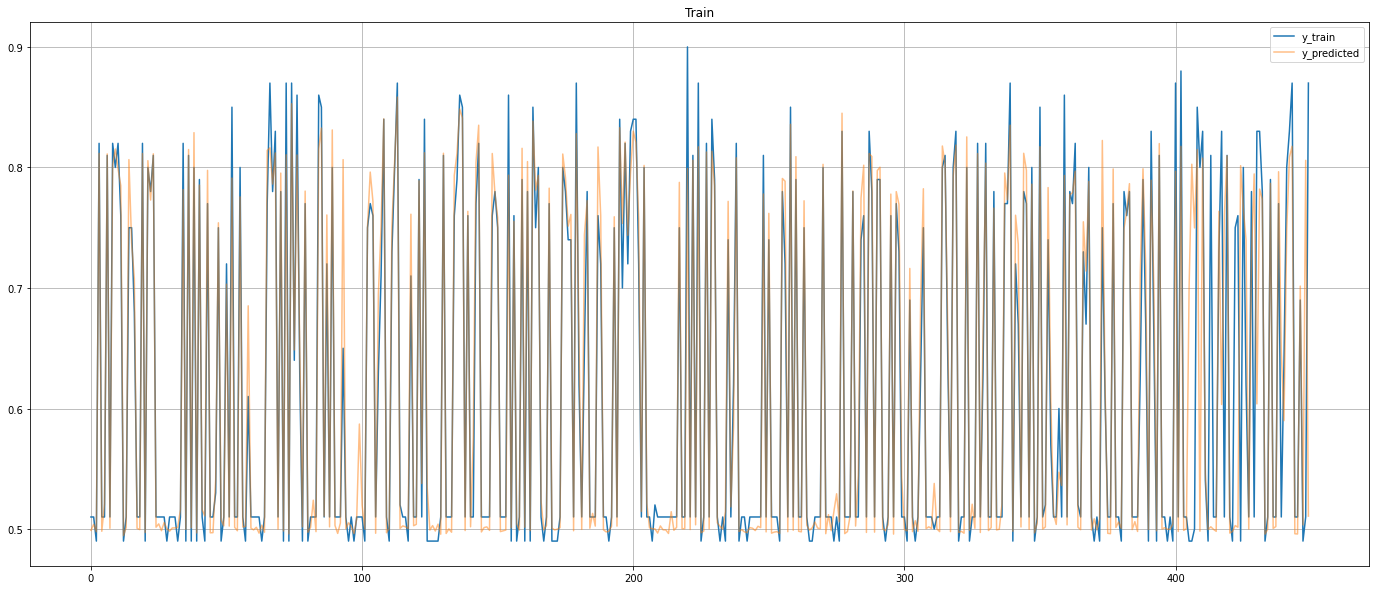

In [19]:
y_predicted_train = model.predict(x_train)

fig = plt.figure(figsize=(24, 10))
plt.plot(np.arange(len(y_train)), y_train, label="y_train")
plt.plot(np.arange(len(y_predicted_train)), y_predicted_train, label="y_predicted", alpha=0.5)
plt.title("Train")
plt.grid()
plt.legend()
# plt.xlim(100,120)
plt.show()

In [20]:
model.save("accuracy_predictor.h5")